<a href="https://colab.research.google.com/github/Balbuenar/Unclassified--repo/blob/master/Petrol_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
dataset = pd.read_csv("/content/gdrive/MyDrive/petrol_consumption.csv")

In [4]:
dataset.shape

(48, 5)

In [5]:
dataset.keys()

Index(['Petrol_tax', 'Average_income', 'Paved_Highways',
       'Population_Driver_licence(%)', 'Petrol_Consumption'],
      dtype='object')

In [6]:
dataset.head()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561
3,7.5,4870,2351,0.529,414
4,8.0,4399,431,0.544,410


Discussion:
Suppose we want to do Linear Regression on our dataset to get an estimate, based on mean squared error, of how well our model will perform on data outside our dataset.

Suppose also that our data is split into three folds: Fold 1, Fold 2, and Fold 3.

What would the steps be, in English, to do this?

Your response below

Coding this up
The KFold object in SciKit Learn tells the cross validation object (see below) how to split up the data:

In [7]:
X = dataset.drop('Petrol_Consumption', axis=1)
y = dataset.Petrol_Consumption

In [8]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [9]:
kf.split(X)

<generator object _BaseKFold.split at 0x7fd76a6287d8>

In [10]:
X.shape

(48, 4)

In [11]:
X.tail()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%)
43,7.0,3745,2611,0.508
44,6.0,5215,2302,0.672
45,9.0,4476,3942,0.571
46,7.0,4296,4083,0.623
47,7.0,5002,9794,0.593


In [12]:
for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:",test_index[:10], len(test_index))
    print('')

Train index: [ 0  1  2  4  5  7  8 10 12 15] 32
Test index: [ 3  6  9 11 13 14 18 19 25 27] 16

Train index: [ 2  3  5  6  8  9 10 11 12 13] 32
Test index: [ 0  1  4  7 15 17 26 28 30 31] 16

Train index: [ 0  1  3  4  6  7  9 11 13 14] 32
Test index: [ 2  5  8 10 12 16 20 21 22 23] 16



In [13]:
#from sklearn.metrics import r2_score, mean_squared_error

scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
scores

[0.7017166726032875, 0.5408566834972458, 0.5583743341459353]

### Discussion (Part 2): 

Now suppose we want to do the same, but appropriately scaling our data as we go through the folds.

What would the steps be _now_?

In [14]:
scores = []

lr = LinearRegression()
s = StandardScaler()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    X_train_s = s.fit_transform(X_train)
    
    lr.fit(X_train_s, y_train)
    
    X_test_s = s.transform(X_test)
    
    y_pred = lr.predict(X_test_s)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)

In [15]:
scores

[0.7017166726032883, 0.5408566834972457, 0.5583743341459347]

(same scores, because for vanilla linear regression with no regularization, scaling actually doesn't matter for performance)

This is getting quite cumbersome! 

_Very_ luckily, SciKit Learn has some wonderful functions that handle a lot of this for us.

### `Pipeline` and `cross_val_predict`

Pipeline lets you chain together multiple operators on your data that both have a fit method.

In [16]:
s = StandardScaler()
lr = LinearRegression()

### Combine multiple processing steps into a Pipeline
A pipeline contains a series of steps, where a step is ("name of step", actual_model). The "name of step" string is only used to help you identify which step you are on, and to allow you to specify parameters at that step.

In [17]:
estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

In [18]:
estimator.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [19]:
estimator.predict(X_test)

array([560.00408745, 404.30933052, 477.45432197, 487.29144751,
       564.27043016, 599.85130396, 707.60559346, 561.62671887,
       388.20749602, 436.19633625, 489.69871415, 445.61335864,
       606.70602534, 647.20695471, 731.68248338, 574.49672119])

### cross_val_predict¶
cross_val_predict is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

In [20]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

In [21]:
predictions = cross_val_predict(estimator, X, y, cv=kf)

In [22]:
len(predictions)

48

In [23]:
r2_score(y, predictions)

0.6105004390528358

In [24]:
np.mean(scores) # almost identical!

0.6003158967488229

### Hyperparameter tuning
#### Definition
Hyperparameter tuning involves using cross validation (or train-test split) to determine which hyperparameters are most likely to generate a model that generalizes well outside of your sample.

#### Mechanics
We can generate an exponentially spaces range of values using the numpy geomspace function.

np.geomspace(1, 1000, num=4)
produces:

array([    1.,    10.,   100.,  1000.])
Use this function to generate a list of length 10 called alphas for hyperparameter tuning:

In [25]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

The code below tunes the alpha hyperparameter for Lasso regression.

In [26]:
scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

In [27]:
list(zip(alphas,scores))

[(1e-09, 0.6105004390591973),
 (1e-08, 0.6105004391164308),
 (1e-07, 0.6105004396916721),
 (1e-06, 0.6105004454507883),
 (1e-05, 0.6105005033458499),
 (0.0001, 0.6105010812886296),
 (0.001, 0.61050680053286),
 (0.01, 0.6105643511619387),
 (0.1, 0.6111318580577028),
 (1.0, 0.6158565247629548)]

In [28]:
Lasso(alpha=1e-6).fit(X, y).coef_

array([-3.47901580e+01, -6.65887451e-02, -2.42589059e-03,  1.33644896e+03])

In [29]:
Lasso(alpha=1.0).fit(X, y).coef_

array([-4.35894133e+01, -5.99092343e-02, -4.13243720e-03,  9.43357424e+02])

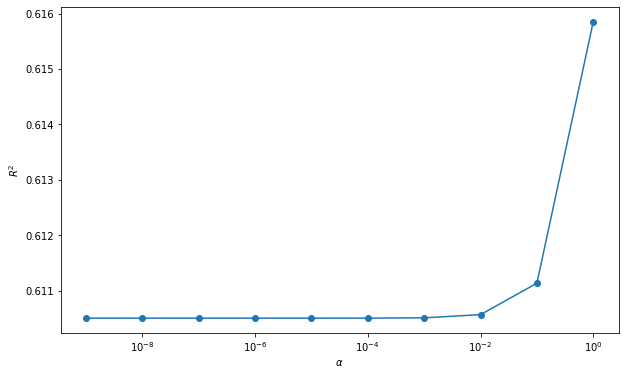

In [30]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

### Exercise
Add PolynomialFeatures to this Pipeline, and re-run the cross validation with the PolynomialFeatures added.

#### Hint #1: pipelines process input from first to last. Think about the order that it would make sense to add Polynomial Features to the data in sequence and add them in the appropriate place in the pipeline.

#### Hint #2: you should see a significant increase in cross validation accuracy from doing this

In [31]:
pf = PolynomialFeatures(degree=3)

scores = []
alphas = np.geomspace(0.06, 6.0, 20)
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

In [32]:
alphas

array([0.06      , 0.0764565 , 0.0974266 , 0.12414828, 0.15819905,
       0.2015891 , 0.25687994, 0.32733569, 0.41711568, 0.53152007,
       0.67730274, 0.86306993, 1.09978843, 1.40143288, 1.78581086,
       2.27561411, 2.89975814, 3.69508927, 4.70855982, 6.        ])

In [33]:
scores

[-10.033663104790428,
 -8.816117593421122,
 -8.7188858441567,
 -9.845556551530416,
 -10.461529795919867,
 -9.981663088267279,
 -10.183996288825838,
 -7.961911825405821,
 -6.235150565584016,
 -4.66783244409745,
 -3.7521517544500798,
 -3.7011303162430806,
 -3.6941106479082144,
 -3.470123467207258,
 -3.207002817328049,
 -2.822445243640689,
 -2.489793556541159,
 -2.1937391298981264,
 -1.9626169144545718,
 -1.6654884877767855]

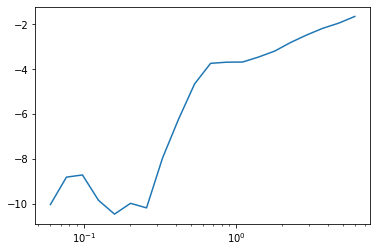

In [34]:
plt.semilogx(alphas, scores);

In [35]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.7996648724875631

In [36]:
best_estimator.named_steps["lasso_regression"].coef_

array([  0.        , -25.39177543, -54.49590474,  -5.72327172,
        70.58708746,   8.74648122,  26.41648306,  15.27794607,
       -30.63655538, -14.81371958,   9.02861099,  18.71406467,
         5.30092588, -23.59501191,   4.85586125])

### Exercise
Do the same, but with Ridge regression

Which model, Ridge or Lasso, performs best with its optimal hyperparameters on the dataset?

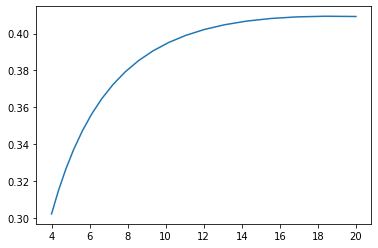

In [37]:
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(4, 20, 20)
scores=[]
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    score = r2_score(y, predictions)
    scores.append(score)

plt.plot(alphas, scores)

**Conclusion:** Both Lasso and Ridge with proper hyperparameter tuning give better results than plain ol' Linear Regression!

**Exercise:**
Now, for whatever your best overall hyperparameter was:

Standardize the data

Fit and predict on the entire dataset

See what the largest coefficients were

Hint: use

dict(zip(model.coef_, pf.get_feature_names()))
for your model model to get the feature names from PolynomialFeatures.

Then, use

dict(zip(list(range(len(X.columns.values))), X.columns.values))
to see which features in the PolynomialFeatures DataFrame correspond to which columns in the original DataFrame.

In [38]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("make_higher_degree", PolynomialFeatures(degree=2, include_bias=False)),
                    ("scaler", s),
                    ("lasso_regression", Lasso(alpha=0.01))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47623.69057613884, tolerance: 58.836647916666664
  positive)


0.7986990072322395

In [39]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names(),
                 best_estimator.named_steps["lasso_regression"].coef_,
))

In [40]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.7996648724875631

In [41]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names(input_features=X.columns),
                 best_estimator.named_steps["lasso_regression"].coef_,
))

In [42]:
df_importances.sort_values(by=1)

,0,1
2,Average_income,-54.495905
8,Petrol_tax Population_Driver_licence(%),-30.636555
1,Petrol_tax,-25.391775
13,Paved_Highways Population_Driver_licence(%),-23.595012
9,Average_income^2,-14.813720
3,Paved_Highways,-5.723272
0,1,0.000000
14,Population_Driver_licence(%)^2,4.855861
12,Paved_Highways^2,5.300926
5,Petrol_tax^2,8.746481


In [43]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))

In [44]:
col_names_dict

{0: 'Petrol_tax',
 1: 'Average_income',
 2: 'Paved_Highways',
 3: 'Population_Driver_licence(%)'}

In [45]:
df_importances.sort_values(by=1)

,0,1
2,Average_income,-54.495905
8,Petrol_tax Population_Driver_licence(%),-30.636555
1,Petrol_tax,-25.391775
13,Paved_Highways Population_Driver_licence(%),-23.595012
9,Average_income^2,-14.813720
3,Paved_Highways,-5.723272
0,1,0.000000
14,Population_Driver_licence(%)^2,4.855861
12,Paved_Highways^2,5.300926
5,Petrol_tax^2,8.746481


In [46]:
best_estimator.named_steps["make_higher_degree"].get_feature_names(input_features=X.columns)

['1',
 'Petrol_tax',
 'Average_income',
 'Paved_Highways',
 'Population_Driver_licence(%)',
 'Petrol_tax^2',
 'Petrol_tax Average_income',
 'Petrol_tax Paved_Highways',
 'Petrol_tax Population_Driver_licence(%)',
 'Average_income^2',
 'Average_income Paved_Highways',
 'Average_income Population_Driver_licence(%)',
 'Paved_Highways^2',
 'Paved_Highways Population_Driver_licence(%)',
 'Population_Driver_licence(%)^2']

In [47]:
 best_estimator.named_steps["lasso_regression"].coef_

array([  0.        , -25.39177543, -54.49590474,  -5.72327172,
        70.58708746,   8.74648122,  26.41648306,  15.27794607,
       -30.63655538, -14.81371958,   9.02861099,  18.71406467,
         5.30092588, -23.59501191,   4.85586125])

### Grid Search CV
To do cross-validation, we used two techniques:

* use KFolds and manually create a loop to do cross-validation
* use cross_val_predict and score to get a cross-valiated score in a couple of lines.
To do hyper-parameter tuning, we see a general pattern:

* use cross_val_predict and score in a manually written loop over hyperparemeters, then select the best one.
Perhaps not surprisingly, there is a function that does this for us -- GridSearchCV

In [48]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [49]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomial_features',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge_regression',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercep...
        5.27924796,  5.58051751,  5.8989

In [50]:
grid.best_score_, grid.best_params_

(0.6370529481159518,
 {'polynomial_features__degree': 1,
  'ridge_regression__alpha': 5.58051750774668})

In [51]:
y_predict = grid.predict(X)

In [52]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict)

0.6716764507971167

In [53]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([  0.        , -30.89689686, -32.83045687,  -7.32204101,
        65.55194851])

In [54]:
grid.cv_results_

{'mean_fit_time': array([0.0038596 , 0.00330114, 0.0042673 , 0.00327786, 0.00313783,
        0.00272004, 0.00285077, 0.00273498, 0.00263929, 0.00277352,
        0.00422994, 0.00362611, 0.00280364, 0.00282462, 0.00276685,
        0.00281612, 0.00271598, 0.00275771, 0.00271042, 0.00276709,
        0.00269326, 0.0027597 , 0.00268459, 0.00297523, 0.00283178,
        0.0027136 , 0.00281707, 0.00275071, 0.00272544, 0.00267879,
        0.00273188, 0.00283647, 0.00285085, 0.00274777, 0.00275389,
        0.00274865, 0.00385539, 0.00361037, 0.00285188, 0.00282637,
        0.00280658, 0.0028437 , 0.00282637, 0.00288161, 0.00273514,
        0.00276224, 0.00281517, 0.00272012, 0.00277702, 0.0027833 ,
        0.00284028, 0.00277106, 0.00290203, 0.00285109, 0.00418115,
        0.00435678, 0.00328581, 0.00318877, 0.00286913, 0.00272703,
        0.00371774, 0.00428009, 0.00412742, 0.00443053, 0.00410978,
        0.00348838, 0.00408268, 0.00286794, 0.00291697, 0.00286937,
        0.00283694, 0.0027589 ,

In [55]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomial_features__degree,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003860,0.000785,0.001917,0.000244,1,4,"{'polynomial_features__degree': 1, 'ridge_regr...",0.754664,0.506357,0.644840,0.635287,0.101596,11
1,0.003301,0.000523,0.001336,0.000103,1,4.22827,"{'polynomial_features__degree': 1, 'ridge_regr...",0.754752,0.504471,0.648213,0.635812,0.102552,9
2,0.004267,0.001406,0.001543,0.000186,1,4.46956,"{'polynomial_features__degree': 1, 'ridge_regr...",0.754656,0.502487,0.651632,0.636259,0.103520,8
3,0.003278,0.000668,0.001951,0.000524,1,4.72462,"{'polynomial_features__degree': 1, 'ridge_regr...",0.754361,0.500402,0.655087,0.636617,0.104498,6
4,0.003138,0.000396,0.001283,0.000010,1,4.99424,"{'polynomial_features__degree': 1, 'ridge_regr...",0.753849,0.498210,0.658568,0.636876,0.105485,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.002838,0.000025,0.001460,0.000034,3,16.0184,"{'polynomial_features__degree': 3, 'ridge_regr...",-5.387809,0.436739,0.467324,-1.494582,2.752956,65
86,0.002868,0.000116,0.001420,0.000005,3,16.9326,"{'polynomial_features__degree': 3, 'ridge_regr...",-5.259179,0.432275,0.455113,-1.457264,2.688376,64
87,0.002968,0.000230,0.001496,0.000100,3,17.8989,"{'polynomial_features__degree': 3, 'ridge_regr...",-5.127540,0.427860,0.443804,-1.418625,2.622607,63
88,0.002745,0.000038,0.001496,0.000045,3,18.9203,"{'polynomial_features__degree': 3, 'ridge_regr...",-4.993132,0.423497,0.433477,-1.378719,2.555779,62


### Lasso with and without scaling
We discussed Lasso in lecture.

Let's review together:

What is different about Lasso vs. regular Linear Regression?
Is standardization more or less important with Lasso vs. Linear Regression? Why?

In [56]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

## Create polynomial features
PolynomialFeatures

In [57]:
pf = PolynomialFeatures(degree=2, include_bias=False,)
X_pf = pf.fit_transform(X)

**Note:** We use include_bias=False since Lasso includes a bias by default.

In [58]:
X_pf_ss = s.fit_transform(X_pf)

## Lasso
Lasso documentation

In [59]:
las = Lasso()
las.fit(X_pf_ss, y)
las.coef_ 

array([  0.        , -17.64314015,  -0.        ,   0.        ,
         4.92812486,  -0.        ,   0.        , -41.20456677,
       -20.74293952,  -0.        ,   0.        ,  -3.29161187,
        -5.63225979, 103.18561845])

## Exercise
Compare

* Sum of magnitudes of the coefficients
* Number of coefficients that are zero
for Lasso with alpha 0.1 vs. 1.

Before doing the exercise, answer the following questions in one sentence each:

* Which do you expect to have greater magnitude?
* Which do you expect to have more zeros?

In [60]:
las01 = Lasso(alpha = 0.1)
las01.fit(X_pf_ss, y)
print('sum of coefficients:', abs(las01.coef_).sum() )
print('number of coefficients not equal to 0:', (las01.coef_!=0).sum())

sum of coefficients: 1680.296532559976
number of coefficients not equal to 0: 14


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10014.054421865992, tolerance: 58.836647916666664
  positive)


In [61]:
las1 = Lasso(alpha = 1)
las1.fit(X_pf_ss, y)
print('sum of coefficients:',abs(las1.coef_).sum() )
print('number of coefficients not equal to 0:',(las1.coef_!=0).sum())

sum of coefficients: 196.62826141518
number of coefficients not equal to 0: 7


With more regularization (higher alpha) we will expect the penalty for higher weights to be greater and thus the coefficients to be pushed down. Thus a higher alpha means lower magnitude with more coefficients pushed down to 0.

## Exercise:  𝑅2 
Calculate the  𝑅2  of each model without train/test split.

Recall that we import  𝑅2  using:

from sklearn.metrics import r2_score

In [62]:
from sklearn.metrics import r2_score
r2_score(y,las.predict(X_pf_ss))

0.7093600182448968

#### Discuss:
Will regularization ever increase model performance if we evaluate on the same dataset that we trained on?

## With train/test split
Discuss
Are there any issues with what we've done so far?

Hint: Think about the way we have done feature scaling.

Discuss in groups of two or three.

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.3, 
                                                    random_state=72018)

In [65]:
X_train_s = s.fit_transform(X_train)
las.fit(X_train_s, y_train)
X_test_s = s.transform(X_test)
y_pred = las.predict(X_test_s)
r2_score(y_pred, y_test)

0.4609769497766186

In [67]:
X_train_s = s.fit_transform(X_train)
las01.fit(X_train_s, y_train)
X_test_s = s.transform(X_test)
y_pred = las01.predict(X_test_s)
r2_score(y_pred, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14443.304354670407, tolerance: 37.11060606060606
  positive)


0.19446723255352427

### Exercise
#### Part 1:
Do the same thing with Lasso of:

alpha of 0.001
Increase max_iter to 100000 to ensure convergence.
Calculate the  𝑅2  of the model.

Feel free to copy-paste code from above, but write a one sentence comment above each line of code explaining why you're doing what you're doing.

#### Part 2:
Do the same procedure as before, but with Linear Regression.

Calculate the  𝑅2  of this model.

#### Part 3:
Compare the sums of the absolute values of the coefficients for both models, as well as the number of coefficients that are zero. Based on these measures, which model is a "simpler" description of the relationship between the features and the target?

In [68]:
# Part 1

# Decreasing regularization and ensuring convergence
las001 = Lasso(alpha = 0.001, max_iter=100000)

# Transforming training set to get standardized units
X_train_s = s.fit_transform(X_train)

# Fitting model to training set
las001.fit(X_train_s, y_train)

# Transforming test set using the parameters defined from training set
X_test_s = s.transform(X_test)

# Finding prediction on test set
y_pred = las001.predict(X_test_s)

# Calculating r2 score
print("r2 score for alpha = 0.001:", r2_score(y_pred, y_test))


# Part 2

# Using vanilla Linear Regression
lr = LinearRegression()

# Fitting model to training set
lr.fit(X_train_s, y_train)

# predicting on test set
y_pred_lr = lr.predict(X_test_s)

# Calculating r2 score
print("r2 score for Linear Regression:", r2_score(y_pred_lr, y_test))


# Part 3
print('Magnitude of Lasso coefficients:', abs(las001.coef_).sum())
print('Number of coeffients not equal to 0 for Lasso:', (las001.coef_!=0).sum())

print('Magnitude of Linear Regression coefficients:', abs(lr.coef_).sum())
print('Number of coeffients not equal to 0 for Linear Regression:', (lr.coef_!=0).sum())

r2 score for alpha = 0.001: -0.5002390690094176
r2 score for Linear Regression: -0.5057452957820394
Magnitude of Lasso coefficients: 2846.7631898942163
Number of coeffients not equal to 0 for Lasso: 14
Magnitude of Linear Regression coefficients: 2884.974684303446
Number of coeffients not equal to 0 for Linear Regression: 14


### L1 vs. L2 Regularization
As mentioned in the deck: Lasso and Ridge regression have the same syntax in SciKit Learn.

Now we're going to compare the results from Ridge vs. Lasso regression:

Ridge

In [69]:
from sklearn.linear_model import Ridge

### Exercise
Following the Ridge documentation from above:

1. Define a Ridge object r with the same alpha as las001.
2. Fit that object on X and y and print out the resulting coefficients.

In [70]:
r = Ridge(alpha = 0.001)
X_train_s = s.fit_transform(X_train)
r.fit(X_train_s, y_train)
X_test_s = s.transform(X_test)
y_pred_r = r.predict(X_test_s)

# Calculating r2 score
r.coef_

array([  -9.3679424 ,   18.03085649,  411.94093985, -171.04496261,
         77.57747323,  135.97430869,  -18.40180212, -149.55365378,
         60.56000832,  131.21960254, -343.63493358,  -30.72697267,
       -504.17653575,  598.17096961])

In [71]:
las001 # same alpha as Ridge above

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [72]:
las001.coef_

array([ -10.32198084,   42.89950165,  445.39851412, -206.09500118,
         76.33743329,  122.61459552,  -30.64699829, -138.06071389,
         69.25257543,  130.60571358, -377.16110261,  -31.92112376,
       -522.90055619,  642.54737955])

In [73]:
print(np.sum(np.abs(r.coef_)))
print(np.sum(np.abs(las001.coef_)))

print(np.sum(r.coef_ != 0))
print(np.sum(las001.coef_ != 0))

2660.3809616393246
2846.7631898942163
14
14


**Conclusion**: Ridge does not make any coefficients 0. In addition, on this particular dataset, Lasso provides stronger overall regularization than Ridge for this value of alpha (not necessarily true in general).

In [74]:
y_pred = r.predict(X_pf_ss)
print(r2_score(y, y_pred))

y_pred = las001.predict(X_pf_ss)
print(r2_score(y, y_pred))

-0.05669364636345975
-0.11067691671508317


# Example: Does it matter when you scale?

In [76]:
from sklearn.preprocessing import StandardScaler

In [77]:
s = StandardScaler()
X_ss = s.fit_transform(X)

In [78]:
lr2 = LinearRegression()
lr2.fit(X_ss, y)
print(lr2.coef_) # coefficients now "on the same scale"

[-32.7310515  -37.79691223  -8.3813148   73.3569154 ]


In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_ss, y, test_size=0.3, 
                                                    random_state=72018)

In [80]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2_score(y_pred, y_test)

0.75392809099585

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=72018)

In [82]:
s = StandardScaler()
lr_s = LinearRegression()
X_train_s = s.fit_transform(X_train)
lr_s.fit(X_train_s, y_train)
X_test_s = s.transform(X_test)
y_pred_s = lr_s.predict(X_test_s)
r2_score(y_pred_s, y_test)

0.7539280909958498

In [ ]:
X = dataset[['Petrol_tax', 'Average_income', 'Paved_Highways',
       'Population_Driver_licence(%)']]
y = dataset['Petrol_Consumption']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Training the Algorithm
And finally, to train the algorithm we execute the same code as before, using the fit() method of the LinearRegression class:

In [83]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

As said earlier, in case of multivariable linear regression, the regression model has to find the most optimal coefficients for all the attributes. To see what coefficients our regression model has chosen, execute the following script:

In [84]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
Petrol_tax,-27.728412
Average_income,-0.080467
Paved_Highways,-0.001665
Population_Driver_licence(%),1503.937881


This means that for a unit increase in "petrol_tax", there is a decrease of 24.19 million gallons in gas consumption. Similarly, a unit increase in proportion of population with a drivers license results in an increase of 1.324 billion gallons of gas consumption. We can see that "Average_income" and "Paved_Highways" have a very little effect on the gas consumption.

### Making Predictions
To make pre-dictions on the test data, execute the following script:

In [85]:
y_pred = regressor.predict(X_test)

To compare the actual output values for X_test with the predicted values, execute the following script:

In [86]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
3,414,479.232274
36,640,644.892433
13,508,563.467888
11,471,432.912578
43,591,551.605906
41,699,639.196405
38,648,750.871143
14,566,645.528712
18,865,792.822414
27,631,625.655341


### Evaluating the Algorithm
The final step is to evaluate the performance of algorithm. We'll do this by finding the values for MAE, MSE and RMSE. Execute the following script:

In [87]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 53.8246035497069
Mean Squared Error: 3739.1040706080316
Root Mean Squared Error: 61.148213960900215


You can see that the value of root mean squared error is 60.07, which is slightly greater than 10% of the mean value of the gas consumption in all states. This means that our algorithm was not very accurate but can still make reasonably good predictions.

There are many factors that may have contributed to this inaccuracy, a few of which are listed here:

1. Need more data: Only one year worth of data isn't that much, whereas having multiple years worth could have helped us improve the accuracy quite a bit.
2. Bad assumptions: We made the assumption that this data has a linear relationship, but that might not be the case. Visualizing the data may help you determine that.
3. Poor features: The features we used may not have had a high enough correlation to the values we were trying to predict.